In [1]:
import pandas as pd
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
import re
from string import punctuation
import pymorphy2
import numpy as np
from scipy.linalg import eigh
import nltk
import torch
import pickle
import matplotlib.pyplot as plt
import torchmetrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from razdel import tokenize
from navec import Navec


d:\5semak\NLP_5_semak\NLP\lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


In [2]:
navec = Navec.load('../navec_hudlit_v1_12B_500K_300d_100q.tar')


In [3]:
rus_stop_words = stopwords.words("russian")
symbols = list(punctuation) + ['\t', '\n', '\r',
                               '№', '#', '@', '^', '%', '*', '»', '«', ]
emojy = [
    '\xeb',
    '\ufffc',
    '\xbf',
    '\u2011',
    '\u200b'
]
morph = pymorphy2.MorphAnalyzer(lang='ru')


# Task 1
Загрузите датасет из ЛР1. Датасет большой, рекомендуется для работы взять его часть (далее - корпус).

In [4]:
df = pd.read_csv('../Data/Petitions.csv')
df


,id,public_petition_text,reason_category
0,3168490,снег на дороге,Благоустройство
1,3219678,очистить кабельный киоск от рекламы,Благоустройство
2,2963920,"Просим убрать все деревья и кустарники, которы...",Благоустройство
3,3374910,Неудовлетворительное состояние парадной - надп...,Содержание МКД
4,3336285,Граффити,Благоустройство
...,...,...,...
59884,3128111,прошу закрасить граффити,Благоустройство
59885,3276713,Прошу вас отремонтировать пешеходную дорожку,Благоустройство
59886,3274663,Необходимо демонтировать незаконную рекламную ...,Незаконная информационная и (или) рекламная ко...
59887,3359308,Очень гремит на ветру металлическая часть окна...,Кровля


# Task 2
Рассмотрите каждый объект корпуса как отдельный текстовый документ. Выполните предварительную обработку каждого объекта.

In [5]:
public_petition_text = df['public_petition_text']


In [6]:
def filter_fun(text):
    is_not_symbol = True
    for i in text:
        if i in symbols:
            is_not_symbol = False
    is_not_num = not bool(re.match('\d+', text))
    is_not_stop_word = not text in rus_stop_words
    return is_not_num and is_not_symbol and is_not_stop_word


In [7]:
def text_preprocessed(text: str):
    text = text.lower()
    for i in emojy:
        text = text.replace(i, '')
    text = nltk.tokenize.word_tokenize(text)
    text = list(filter(filter_fun, text))
    text = list(map(lambda i: morph.parse(i)[0].normal_form, text))
    return ' '.join(text)


In [8]:
df['public_petition_text_modded'] = public_petition_text.apply(text_preprocessed)


In [9]:
df = df.drop('public_petition_text', axis=1)


In [10]:
df.head()

,id,reason_category,public_petition_text_modded
0,3168490,Благоустройство,снег дорога
1,3219678,Благоустройство,очистить кабельный киоск реклама
2,2963920,Благоустройство,просить убрать дерево кустарник который выйти ...
3,3374910,Содержание МКД,неудовлетворительный состояние парадный надпис...
4,3336285,Благоустройство,граффити


In [11]:
df.to_csv('../Data/modded.csv')

# Task 3
Выполните векторизацию каждого документа любым способом (можно с помощью своих моделей Word2Vec, при условии, что Word2Vec модели обучались на той же выборке документов; можно использовать другие библиотеки и модели).

In [12]:
def vectorizer(text):
    return sum(map(lambda a: navec[a] if a in navec else navec['<unk>'], text.split(' ')))


In [13]:
public_petition_text_vector = df['public_petition_text_modded'].apply(vectorizer)


In [14]:
df_vectored = df.drop(['public_petition_text_modded'], axis=1)
df_vectored['public_petition_text_vectored'] = public_petition_text_vector


In [15]:
df_vectored.head()


,id,reason_category,public_petition_text_vectored
0,3168490,Благоустройство,"[0.29590172, -1.2651815, 0.37506878, -0.427091..."
1,3219678,Благоустройство,"[0.56108713, -0.2537534, 0.26748753, -0.421476..."
2,2963920,Благоустройство,"[1.4993877, -7.6264415, 1.3750213, -2.3595083,..."
3,3374910,Содержание МКД,"[0.8002656, -0.74999213, 0.4285491, -1.3885938..."
4,3336285,Благоустройство,"[-0.19770631, 0.08428149, 0.2634739, 0.0454894..."


# Task 4 
Закодируйте значения целевого признака (категория обращения). Разделите данные на обучающую и тестирующую выборку.

In [16]:
df['reason_category'].value_counts()


reason_category
Благоустройство                                                                     34769
Содержание МКД                                                                      14461
Нарушение правил пользования общим имуществом                                        2170
Незаконная информационная и (или) рекламная конструкция                              1831
Фасад                                                                                1483
Повреждения или неисправность элементов уличной инфраструктуры                       1164
Кровля                                                                                825
Водоснабжение                                                                         809
Состояние рекламных или информационных конструкций                                    673
Санитарное состояние                                                                  434
Центральное отопление                                                               

In [17]:
with open('../Data/problems_number.pkl', 'wb') as f:
    pickle.dump(dict(enumerate(df['reason_category'].factorize()[1])), f)

In [18]:
with open('../Data/problems_number.pkl', 'rb') as f:
    problems_number = pickle.load(f)


In [19]:
def factorizerProb(id: int):
    v = np.zeros(max(problems_number)+1)
    v[id] = 1
    return v


In [20]:
df_vectored['reason_category'] = df['reason_category'].factorize()[0]


In [21]:
df_vectored['reason_category2'] = df_vectored['reason_category'].apply(factorizerProb)


In [22]:
df_vectored


,id,reason_category,public_petition_text_vectored,reason_category2
0,3168490,0,"[0.29590172, -1.2651815, 0.37506878, -0.427091...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,3219678,0,"[0.56108713, -0.2537534, 0.26748753, -0.421476...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,2963920,0,"[1.4993877, -7.6264415, 1.3750213, -2.3595083,...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,3374910,1,"[0.8002656, -0.74999213, 0.4285491, -1.3885938...","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,3336285,0,"[-0.19770631, 0.08428149, 0.2634739, 0.0454894...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...
59884,3128111,0,"[0.38387415, -0.13600658, 0.31474167, 0.000557...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
59885,3276713,0,"[0.61508846, -0.92907864, 0.6802722, -1.201326...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
59886,3274663,2,"[0.18860286, -0.08216125, 0.5107379, -1.675691...","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
59887,3359308,7,"[-0.30990747, -2.406936, 1.2886531, -0.1675881...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."


In [23]:
df_vectored['reason_category'].value_counts()


reason_category
0     34769
1     14461
5      2170
2      1831
3      1483
6      1164
7       825
4       809
8       673
12      434
13      284
10      254
14      251
9       243
11      238
Name: count, dtype: int64

In [24]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler


In [25]:
X, y = SMOTE(
    sampling_strategy='all',
    n_jobs=4
).fit_resample(
    np.array(df_vectored['public_petition_text_vectored'].to_list()), 
    df_vectored['reason_category'].to_numpy()
)


d:\5semak\NLP_5_semak\NLP\lib\site-packages\imblearn\over_sampling\_smote\base.py:345: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


In [26]:
pd.Series(y).value_counts()

0     34769
1     34769
2     34769
3     34769
4     34769
5     34769
6     34769
7     34769
8     34769
9     34769
10    34769
11    34769
12    34769
13    34769
14    34769
Name: count, dtype: int64

In [27]:
X.shape, np.array(pd.Series(y).apply(factorizerProb).to_list()).shape


((521535, 300), (521535, 15))

In [28]:
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    np.array(pd.Series(y).apply(factorizerProb).to_list()), 
    test_size=0.9,
)


In [29]:
X_train.shape


(52153, 300)

# Task 5
С помощью PyTorch соберите и обучите три нейронных сети для решения задачи классификации (предсказания категории обращения); количество слоев и значения других параметров конфигурируете по вашему усмотрению:
1) сеть на базе блока RNN;
2) сеть на базе блока LSTM;
3) сеть на базе блока GRU.

In [53]:
class CBow(torch.nn.Module):
    def __init__(
        self,
        input_size: int,
        hidden_size_of_first_layer: int,
        num_layers_of_first_layer: int,
        input_size_of_second_layer: int,
        hidden_size_of_second_layer: int,
        num_layers_of_second_layer: int,
        input_size_of_third_layer: int,
        hidden_size_of_third_layer: int,
        num_layers_of_third_layer: int,
        input_size_of_fourth_layer: int,
        output_size_of_fourth_layer: int,
        input_size_of_fifth_layer: int,
        output_size_of_fifth_layer: int,
        output_layer_size: int
    ):
        
        super(CBow, self).__init__()
        self.input_size = input_size
        self.hidden_size_of_first_layer = hidden_size_of_first_layer
        self.num_layers_of_first_layer = num_layers_of_first_layer
        self.input_size_of_second_layer = input_size_of_second_layer
        self.hidden_size_of_second_layer = hidden_size_of_second_layer
        self.num_layers_of_second_layer = num_layers_of_second_layer
        self.input_size_of_third_layer = input_size_of_third_layer
        self.hidden_size_of_third_layer = hidden_size_of_third_layer
        self.num_layers_of_third_layer = num_layers_of_third_layer
        self.input_size_of_fourth_layer = input_size_of_fourth_layer
        self.input_size_of_fifth_layer = input_size_of_fifth_layer
        self.output_layer_size = output_layer_size

        self.input_layer = torch.nn.RNN(
            input_size=input_size,
            hidden_size=hidden_size_of_first_layer,
            num_layers=num_layers_of_first_layer,
            # bidirectional=True
        )
        self.second_layer = torch.nn.LSTM(
            input_size=input_size_of_second_layer,
            hidden_size=hidden_size_of_second_layer,
            num_layers=num_layers_of_second_layer,
            # bidirectional=False
        )
        self.third_layer = torch.nn.GRU(
            input_size=input_size_of_third_layer,
            hidden_size=hidden_size_of_third_layer,
            num_layers=num_layers_of_third_layer,
            # bidirectional=False
        )
        self.fourth_layer = torch.nn.Linear(
            in_features=input_size_of_fourth_layer,
            out_features=output_size_of_fourth_layer,
        )
        self.fifth_layer = torch.nn.Linear(
            in_features=input_size_of_fifth_layer,
            out_features=output_size_of_fifth_layer,
        )

        self.input_activation = torch.nn.Tanh()
        self.second_activation = torch.nn.Tanh()
        self.third_activation = torch.nn.Tanh()
        self.fourth_activation = torch.nn.ReLU()
        # self.output_activation = torch.nn.LogSoftmax()
        self.h1 = torch.zeros(self.num_layers_of_first_layer, self.hidden_size_of_first_layer).requires_grad_().double().to('cuda')
        self.h2 = torch.zeros(self.num_layers_of_second_layer, self.hidden_size_of_second_layer).requires_grad_().double().to('cuda')
        self.h2_1 = torch.zeros(self.num_layers_of_second_layer, self.hidden_size_of_second_layer).requires_grad_().double().to('cuda')
        self.h2_2 = torch.zeros(self.num_layers_of_second_layer, self.hidden_size_of_second_layer).requires_grad_().double().to('cuda')
        self.h3 = torch.zeros(self.num_layers_of_third_layer, self.hidden_size_of_third_layer).requires_grad_().double().to('cuda')

    def forward(self, x):
        y, self.h1 = self.input_layer(x, self.h1.detach().to('cuda'))
        y = self.input_activation(y)
        y, (self.h2_1, self.h2_2) = self.second_layer(y, (self.h2_1.detach().to('cuda'), self.h2_1.detach().to('cuda')))
        y = self.second_activation(y)
        y, self.h3 = self.third_layer(y, self.h3.detach().to('cuda'))
        y = self.third_activation(y)
        y = self.fourth_layer(y)
        y = self.fourth_activation(y)
        y = self.fifth_layer(y)
        return y


Gensim

In [54]:
ds_train = torch.utils.data.TensorDataset(torch.from_numpy(X_train).double(), torch.from_numpy(y_train).double())
dl_train = torch.utils.data.DataLoader(ds_train, batch_size=256, shuffle=True)


In [55]:
model = CBow(
    input_size=300,
    hidden_size_of_first_layer=250,
    num_layers_of_first_layer=3,
    input_size_of_second_layer=250,
    hidden_size_of_second_layer=200,
    num_layers_of_second_layer=2,
    input_size_of_third_layer=200,#100,
    hidden_size_of_third_layer=100,
    num_layers_of_third_layer=2,# y_train.shape[1],
    input_size_of_fourth_layer=100,
    output_size_of_fourth_layer=50,
    input_size_of_fifth_layer=50,
    output_size_of_fifth_layer=15,
    output_layer_size=15# y_train.shape[1]
).double().to('cuda')


In [56]:
loss = torch.nn.MultiLabelSoftMarginLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [57]:
er_list=[]
epochs = 10
for epoch in range(epochs):
    for x_b, y_b in dl_train:
        outputs = model(x_b.to('cuda'))
        # if len(er_list) > 1:
        #     if er_list[-1] < 5:
        #         optimizer = torch.optim.Adam(model.parameters(), lr=0.0000005)
        #     else:
        #         optimizer = torch.optim.Adam(model.parameters(), lr=0.0000005)
        loss_value = loss(outputs, y_b.to('cuda'))
        loss_value.backward(retain_graph=True)
        optimizer.step()
        optimizer.zero_grad()
    er_list.append(loss_value.item())
    print(f'Эпоха {epoch + 1}, Значение функции потерь: {loss_value.item()}')


Эпоха 1, Значение функции потерь: 0.24516368560508023
Эпоха 2, Значение функции потерь: 0.2451052111169347
Эпоха 3, Значение функции потерь: 0.2451234268864214
Эпоха 4, Значение функции потерь: 0.24505103244528603
Эпоха 5, Значение функции потерь: 0.2449121747745351
Эпоха 6, Значение функции потерь: 0.24524206232400983
Эпоха 7, Значение функции потерь: 0.2452511893925666
Эпоха 8, Значение функции потерь: 0.24554834503849415
Эпоха 9, Значение функции потерь: 0.24453651832441334
Эпоха 10, Значение функции потерь: 0.24449404730937532


In [46]:
model.h1

tensor([[ 0.1852,  0.9927, -0.9999,  0.9962, -0.7371, -0.9471, -1.0000,  0.9492,
          0.9050,  0.9983,  0.9851, -0.9715, -0.9999,  0.9998, -0.8736,  0.8558,
          1.0000,  0.4294,  0.9998, -0.9582,  0.9978,  0.9987,  0.9992,  0.9993,
         -0.9991, -0.9999,  0.9857,  0.9991,  1.0000, -0.9996,  0.9983, -0.9952,
         -0.9983, -0.9698, -0.9990,  0.9280, -1.0000,  1.0000, -0.9984,  0.9993,
          0.9990,  0.8397, -0.9992,  0.9982,  0.9806, -0.9997, -0.9399, -0.9997,
          0.9999, -0.9830, -0.9996,  1.0000, -0.9958, -0.9988,  0.3825, -1.0000,
         -0.9997,  0.9994, -0.9666,  0.9993, -0.9993,  0.9939, -0.9992,  1.0000,
         -0.9996,  0.9999, -0.9979, -0.9997, -0.9994, -1.0000, -1.0000,  0.8835,
         -0.2192,  0.9955,  1.0000,  0.9931, -0.9980,  0.9999,  0.8194, -0.9584,
          0.9999,  0.9733,  0.9997, -1.0000,  0.8522,  0.9863, -0.9997,  0.2553,
         -0.9993,  1.0000, -0.9999,  0.9847, -0.9208,  0.9996, -0.7958, -0.9992,
          0.9973,  0.8229,  

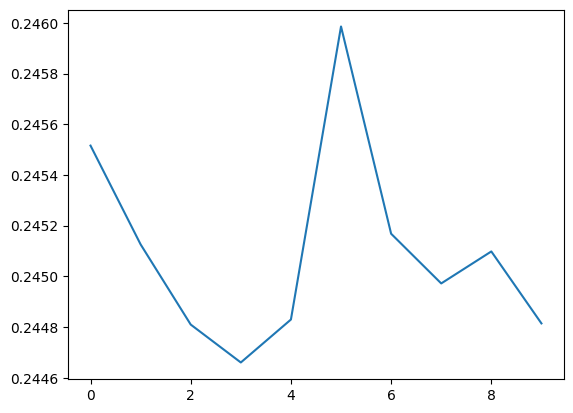

In [47]:
plt.plot(er_list)


# Task 6
Используя известные вам метрики классификации и тестирующую выборку оцените качество каждой из обученных моделей. Сделайте вывод о том, какая из моделей на ваших данных отработала лучше других.

In [48]:
X_, X_test, y_, y_test = train_test_split(
    X,
    np.array(pd.Series(y).apply(factorizerProb).to_list()),
    test_size=0.1,
)


In [49]:
x_t = torch.tensor(X_test).to('cuda').double()
# y_t = torch.tensor(y_test).to('cuda')


In [50]:
torch.save(model, '../Models/Recur.pt')

In [51]:
m = torch.load('../Models/Recur.pt')


In [52]:
pred = model(x_t)


In [42]:
pred


tensor([[-2.8336, -2.5916, -2.6908,  ..., -2.6373, -2.5578, -2.5612],
        [-2.8336, -2.5916, -2.6908,  ..., -2.6373, -2.5578, -2.5612],
        [-2.8336, -2.5916, -2.6908,  ..., -2.6373, -2.5578, -2.5612],
        ...,
        [-2.8336, -2.5916, -2.6908,  ..., -2.6373, -2.5578, -2.5612],
        [-2.8336, -2.5916, -2.6908,  ..., -2.6373, -2.5578, -2.5612],
        [-2.8336, -2.5916, -2.6908,  ..., -2.6373, -2.5578, -2.5612]],
       device='cuda:0', dtype=torch.float64, grad_fn=<AddmmBackward0>)

In [43]:
np.argmin(pred.to('cpu').detach().numpy(), axis=1)


array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [44]:
np.argmax(y_test, axis=1)


array([14,  3,  8, ..., 11,  1, 11], dtype=int64)

In [45]:
print(classification_report(np.argmax(pred.to('cpu').detach().numpy(), axis=1), np.argmax(y_test, axis=1)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0
          10       0.00      0.00      0.00         0
          11       0.00      0.00      0.00         0
          12       0.00      0.00      0.00         0
          13       1.00      0.07      0.12     52154
          14       0.00      0.00      0.00         0

    accuracy                           0.07     52154
   macro avg       0.07      0.00      0.01     52154
weighted avg       1.00   

d:\5semak\NLP_5_semak\NLP\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\5semak\NLP_5_semak\NLP\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\5semak\NLP_5_semak\NLP\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Вывод

Чёт как-то оч не оч.